# Think Bayes: Chapter 13

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from itertools import product
from IPython.display import display
from scipy import stats
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb

'Done'

'Done'

## A simple model

Assume that tumors grow with a constant doubling time.

Tumors are three-dimensional, so when the linear measurements double, the volume gets multiplied by eight:

$v_0 = l_0 \times h_0 \times w_0$

$v_1 = 2 l_0 \times 2 h_0 \times 2 w_0 = 8 v_0$

The median volume doubling time reported by Zhang et. al. is 811 days. For a 3-dimensional geomotry,
this makes the doubling time for a single linear measure three times longer. To solidify this, consider this quick example:

- Tumor has initial volume $v_0 = 1 \times 1 \times 1 = 1$
- Tumor doubles in volume after $d$ days: $v_d = 2\times v_0 = 2 (1 \times 1 \times 1) = 2$
- The linear measures double after $n$ days: $v_n = 2 \times 2 \times 2 = 8$
- How many times did the tumor have to double to get from $v_0$ to $v_n$? 3 times, because $2^3 = 8$.

The patient's diagnosis came 3291 days after discharge from military, with a measurement of 15.5 cm x 15 cm.

Answer the question:

> If this tumor grew at the median rate, how big would it have been at the date of discharge?

In [2]:
# Time between discharge and diagnosis, in days.
interval = 3291

# Linear measure doubling time.
dt = 811 * 3

# How many times has it doubled since discharged?
doublings = interval / dt

# Tumor measure at diagnosis (cm).
m1 = 15.5

# How big was the tumor at time of discharge?
# Solve: m1 = m0 * 2^doublings
m0 = m1 / 2 ** doublings

print('Tumor measure at discharge = %.3lf cm' % m0)

Tumor measure at discharge = 6.069 cm


The computation above indicates the tumor measure was about 6 cm, assuming a median growth rate.

Now compute the growth rate implied if the tumor had formed after the date of discharge.

In [3]:
# Start with a very small measurement.
m0 = 0.1

# Tumor measure at diagnosis (cm).
m1 = 15.5

# How many times would it have doubled to get from m0 to m1?
# Solve m0 * 2^doublings = m1.
doublings = np.log2(m1 / m0)

# What doubling time does that imply?
dt = interval / doublings

# Convert to annual volumetric time.
rdt = 3 * 365 / dt

print('Tumor after discharging implies it would have doubled %.3lf times per year' % rdt)

Tumor after discharging implies it would have doubled 2.421 times per year


## More general model

Given the tumor size at diagnosis, it would be useful to know the probability that the tumor formed before any given date or, equivalently, the distribution of ages.

Use a simulation-based approach with steps:

1. Run simulations of tumor growth to get distribution of size conditioned on age.
2. Use a Bayesian approach to get distribution of age conditioned on size.

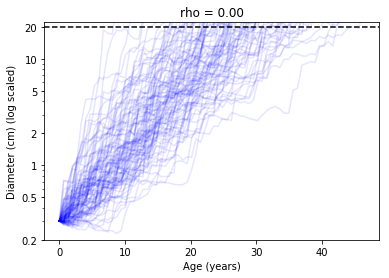

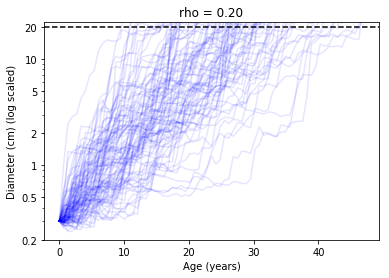

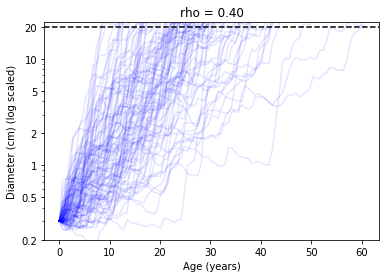

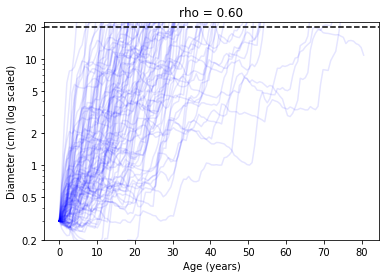

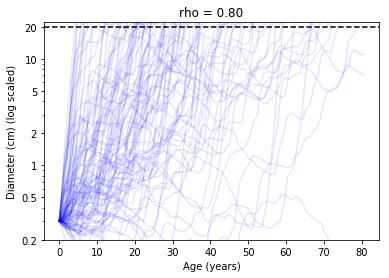

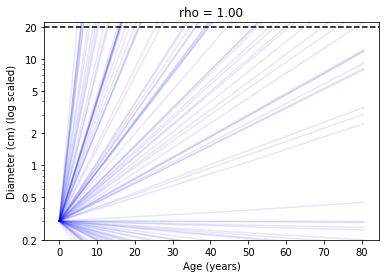

In [12]:
# Helpers to convert volume to diameter and back.

def v2d(V):
    return 2 * ((V / ((4/3) * np.pi)) ** (1/3))

def d2v(D):
    return (4/3) * np.pi * (D / 2)**3

# v2d = lambda V: 2 * ((V / _F) ** (1/3))
# d2v = lambda D: _F * (D / 2)**3

def zhang_RDT_cdf():
    """Uses the data from Zhang et al. to construct a CDF for reciprocal doubling time.
    
    RDT = reciprocal doubling time.
    
    """
    hypos, probs = [], []
    with open('chap13_RDT_PMF.txt', 'r') as fp:
        for l in fp:
            h, p = l.split()
            hypos.append(float(h))
            probs.append(float(p))
    
    return mtb.PMF(hypos, probs).to_cdf()

def correlated_sampler(cdf, rho, n):
    """Generates n-dimensional vectors of correlated samples from the given CDF."""
    
    stdnorm = stats.norm(0, 1)
    
    def transform(X):
        P = stdnorm.cdf(X)
        return np.array([cdf.percentile(p) for p in P])
    
    X = stdnorm.rvs(n)
    yield transform(X)
    
    sigma = np.sqrt(1 - rho**2 + 1e-7)
    while True:
        X = stats.norm.rvs(loc=X * rho, scale=sigma, size=n)
        yield transform(X)

class SimulationResult(mtb.PMF, mtb.Joint):
    pass

def simulate(RDT_cdf=zhang_RDT_cdf(), n_tumors=10, interval=245 / 365, rho=0.3, 
             diameter_min=0.3, diameter_max=20, age_max=80, verbose=False):
    """Runs tumor growth simulation.
    
    # Arguments:
        RDT_cdf: mtb.CDF object of reciprocal doubling time based on Zhang et. al.. RDT uses units of volume.
        n_tumors: How many tumors to simulate.
        interval: Measurement interval in unit years.
        rho: serial correlation for RDT sampling.
        diameter_min: starting radius for tumors, unit cm.
        diameter_max: maximum radius for tumors, unit cm. Simulation terminates when all tumors reach this size.
        
    # Returns:
        mtb.Joint: joint distribution of observed (age, size) pairs from the simulation.
    """
    
    # Correlated sampler for RDT values.
    rdt_sampler = correlated_sampler(RDT_cdf, rho, n_tumors)
    
    # Simulator operates on volumes.
    volume_min, volume_max = d2v(diameter_min), d2v(diameter_max)
    
    # Represent state of tumors with a vector of their volumes.
    volumes = np.ones(n_tumors) * volume_min
    
    # All tumors start at age 0 and increase with each interval.
    age = 0
    
    # Store (age, diameter) counts.
    joint = Counter()
    
    # Record initial volumes.
    joint[(age, diameter_min)] += n_tumors
    
    # Keep a list of diameters for each tumor.
    diameter_sequences = [[diameter_min] for _ in range(n_tumors)]
    
    # Keep a single list of ages.
    age_sequence = [0]
    
    while True:
        
        # Get growth rates for this interval.
        rdts = next(rdt_sampler)
        
        # Increment age - all tumors have the same age.
        age += interval
        age_sequence.append(age)
        
        # Increment volumes.
        growth = 2 ** (rdts * interval)
        volumes *= growth
        volumes = np.maximum(volumes, 0)
        
        # Convert to diameters to record.
        diameters = v2d(volumes)
        
        if verbose:
            print('Tumor age = %.2lf years. Min diameter = %.3lf cm' % (age, diameters.min()))
    
        # Record current volumes.
        for i, d in enumerate(diameters):
            joint[(age, d)] += 1
            diameter_sequences[i].append(d)
            
        # Stop simulation when all tumors have exceeded the maximum size.
        if volumes.min() > volume_max or age > age_max:
            break
            
    hypos, probs = zip(*joint.items())
    return SimulationResult(hypos, probs), age_sequence, diameter_sequences

def plot_simulation(joint, age_sequence, diameter_sequences, title):
    for dseq in diameter_sequences:
        plt.plot(age_sequence, dseq, alpha=0.1, color='blue')

    plt.axhline(20, linestyle='--', color='black')
    plt.yscale('log')
    plt.yticks([0.2, 0.5, 1, 2, 5, 10, 20], [0.2, 0.5, 1, 2, 5, 10, 20])
    plt.ylim(0.2, 22)
    plt.xlabel('Age (years)')
    plt.ylabel('Diameter (cm) (log scaled)')
    plt.title(title)
    plt.show()

# # Test the RDT CDF.
# RDT_cdf = zhang_RDT_cdf()
# RDT_cdf.plot(label='Original')
# mtb.PMF.from_observations(RDT_cdf.sample(1000)).to_cdf().plot(label='Sample')
# plt.legend()
# plt.title('Test RDT sampler')
# plt.show()

# Test the converters.
D = np.random.uniform(0, 100, 100)
assert np.allclose(v2d(d2v(D)), D)

for rho in np.linspace(0, 1, 6):
    title = 'rho = %.2lf' % rho
    plot_simulation(*simulate(n_tumors=100, rho=rho), title)